In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from hpsvm import HPSVM
from mpi4py import MPI

# Apply HPSVM to Mushroom Dataset

In [2]:
df = pd.read_csv("preprocessing_mushroom.csv")

In [3]:
df.head()

,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,...,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat,poisonous
0,5,2,4,1,6,1,0,1,4,0,...,7,7,0,2,1,4,2,3,5,1
1,5,2,9,1,0,1,0,0,4,0,...,7,7,0,2,1,4,3,2,1,0
2,0,2,8,1,3,1,0,0,5,0,...,7,7,0,2,1,4,3,2,3,0
3,5,3,8,1,6,1,0,1,5,0,...,7,7,0,2,1,4,2,3,5,1
4,5,2,3,0,5,1,1,0,4,1,...,7,7,0,2,1,0,3,0,1,0


In [4]:
df.columns

Index(['cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor',
       'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color',
       'stalk-shape', 'stalk-root', 'stalk-surface-above-ring',
       'stalk-surface-below-ring', 'stalk-color-above-ring',
       'stalk-color-below-ring', 'veil-type', 'veil-color', 'ring-number',
       'ring-type', 'spore-print-color', 'population', 'habitat', 'poisonous'],
      dtype='object')

In [5]:
X = df.drop('poisonous', axis=1)
y = df['poisonous']

In [6]:
print(X.describe())

         cap-shape  cap-surface    cap-color      bruises         odor  \
count  8124.000000  8124.000000  8124.000000  8124.000000  8124.000000   
mean      3.348104     1.827671     4.504677     0.415559     4.144756   
std       1.604329     1.229873     2.545821     0.492848     2.103729   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       2.000000     0.000000     3.000000     0.000000     2.000000   
50%       3.000000     2.000000     4.000000     0.000000     5.000000   
75%       5.000000     3.000000     8.000000     1.000000     5.000000   
max       5.000000     3.000000     9.000000     1.000000     8.000000   

       gill-attachment  gill-spacing    gill-size   gill-color  stalk-shape  \
count      8124.000000   8124.000000  8124.000000  8124.000000  8124.000000   
mean          0.974151      0.161497     0.309207     4.810684     0.567208   
std           0.158695      0.368011     0.462195     3.540359     0.495493   
min           0.0

In [7]:
print(y.value_counts())
print(f"Percentage of poisonous mushrooms: {y.mean() * 100:.2f}%")

poisonous
0    4208
1    3916
Name: count, dtype: int64
Percentage of poisonous mushrooms: 48.20%


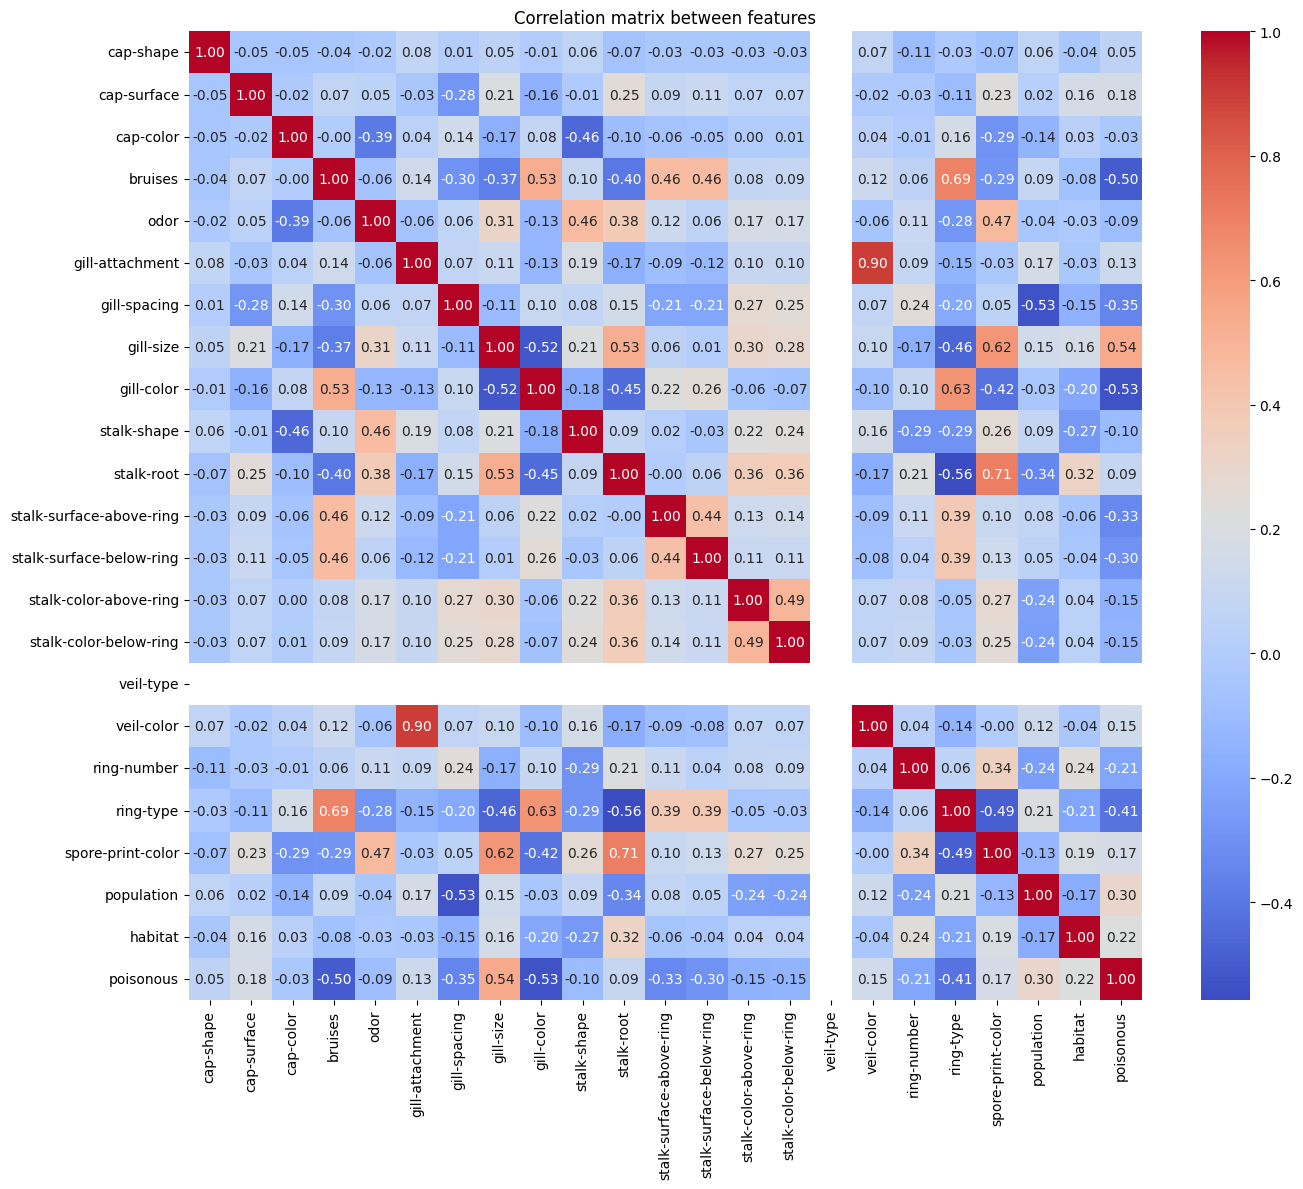

In [8]:
plt.figure(figsize=(14, 12))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation matrix between features')
plt.tight_layout()

In [9]:
# Identify features most correlated with toxicity
corr_with_target = correlation_matrix['poisonous'].drop('poisonous').sort_values(ascending=False)
print("\nFeatures most correlated with toxicity:")
print(corr_with_target.head(5))
print("\nFeatures least correlated with toxicity:")
print(corr_with_target.tail(5))


Features most correlated with toxicity:
gill-size            0.540024
population           0.298686
habitat              0.217179
cap-surface          0.178446
spore-print-color    0.171961
Name: poisonous, dtype: float64

Features least correlated with toxicity:
gill-spacing   -0.348387
ring-type      -0.411771
bruises        -0.501530
gill-color     -0.530566
veil-type            NaN
Name: poisonous, dtype: float64


In [10]:
comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()

In [11]:
if rank == 0:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    print(f"Generated dataset with {X_train.shape[0]} training samples and {X_test.shape[0]} test samples")
else:
    X_train_scaled = None
    X_test_scaled = None
    y_train = None
    y_test = None

Generated dataset with 6499 training samples and 1625 test samples


In [12]:
X_train_scaled = comm.bcast(X_train_scaled, root=0)
X_test_scaled = comm.bcast(X_test_scaled, root=0)
y_train = comm.bcast(y_train, root=0)
y_test = comm.bcast(y_test, root=0)

In [13]:
hpsvm = HPSVM(tau=1.0, tol=1e-4, max_iter=50)

2025-03-12 16:33:07,639 - HPSVM - INFO - Initialized HPSVM with 1 nodes
2025-03-12 16:33:07,642 - HPSVM - INFO - Parameters: tau=1.0, tol=0.0001, max_iter=50, kernel=linear


In [14]:
hpsvm.fit(X_train_scaled, y_train)

2025-03-12 16:33:07,653 - HPSVM - INFO - Starting HPSVM training with 6499 samples and 22 features
2025-03-12 16:33:07,654 - HPSVM - INFO - Data distributed among 1 nodes
2025-03-12 16:33:07,685 - HPSVM - INFO - Iteration 0: duality gap = 0.596438, step size = 0.234427
2025-03-12 16:33:07,731 - HPSVM - INFO - Iteration 5: duality gap = 0.496654, step size = 0.000002
2025-03-12 16:33:07,766 - HPSVM - INFO - Iteration 10: duality gap = 0.524695, step size = 0.000002
2025-03-12 16:33:07,779 - HPSVM - INFO - Iteration 15: duality gap = 0.524743, step size = 0.000000
2025-03-12 16:33:07,789 - HPSVM - INFO - Iteration 20: duality gap = 0.524743, step size = 0.000000
2025-03-12 16:33:07,799 - HPSVM - INFO - Iteration 25: duality gap = 0.524743, step size = 0.000000
2025-03-12 16:33:07,810 - HPSVM - INFO - Iteration 30: duality gap = 0.524743, step size = 0.000000
2025-03-12 16:33:07,820 - HPSVM - INFO - Iteration 35: duality gap = 0.524743, step size = 0.000000
2025-03-12 16:33:07,834 - HPSVM

In [15]:
y_pred = hpsvm.predict(X_test_scaled)

In [16]:
# HPSVM returns a non-poisonous mushroom result as -1, which is replaced by 0
def replace_minus_one(data):
    return np.where(data == -1, 0, data)

In [17]:
y_pred = replace_minus_one(y_pred)

In [18]:
# Evaluate the model
Conf_matrix = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')
print('Classification Report:')
print(classification_report(y_test, y_pred))
print("Confusion matrix: ")
print(Conf_matrix)

Accuracy: 0.9532307692307692
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.96      0.96       842
           1       0.95      0.95      0.95       783

    accuracy                           0.95      1625
   macro avg       0.95      0.95      0.95      1625
weighted avg       0.95      0.95      0.95      1625

Confusion matrix: 
[[807  35]
 [ 41 742]]


# Apply HPSVM to Wholesale customers data

In [19]:
df = pd.read_csv("data/wholesale_customers_data.csv", index_col=0)

In [20]:
df.head()

,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
Channel,,,,,,,
2,3,12669,9656,7561,214,2674,1338
2,3,7057,9810,9568,1762,3293,1776
2,3,6353,8808,7684,2405,3516,7844
1,3,13265,1196,4221,6404,507,1788
2,3,22615,5410,7198,3915,1777,5185


In [21]:
df.columns

Index(['Region', 'Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper',
       'Delicassen'],
      dtype='object')

In [22]:
null_count = df.isnull().sum()
null_count

Region              0
Fresh               0
Milk                0
Grocery             0
Frozen              0
Detergents_Paper    0
Delicassen          0
dtype: int64

In [23]:
X = df.drop('Region', axis=1)
y = df['Region']

In [24]:
print(X.describe())

               Fresh          Milk       Grocery        Frozen  \
count     440.000000    440.000000    440.000000    440.000000   
mean    12000.297727   5796.265909   7951.277273   3071.931818   
std     12647.328865   7380.377175   9503.162829   4854.673333   
min         3.000000     55.000000      3.000000     25.000000   
25%      3127.750000   1533.000000   2153.000000    742.250000   
50%      8504.000000   3627.000000   4755.500000   1526.000000   
75%     16933.750000   7190.250000  10655.750000   3554.250000   
max    112151.000000  73498.000000  92780.000000  60869.000000   

       Detergents_Paper    Delicassen  
count        440.000000    440.000000  
mean        2881.493182   1524.870455  
std         4767.854448   2820.105937  
min            3.000000      3.000000  
25%          256.750000    408.250000  
50%          816.500000    965.500000  
75%         3922.000000   1820.250000  
max        40827.000000  47943.000000  


In [25]:
print(y.value_counts())

Region
3    316
1     77
2     47
Name: count, dtype: int64


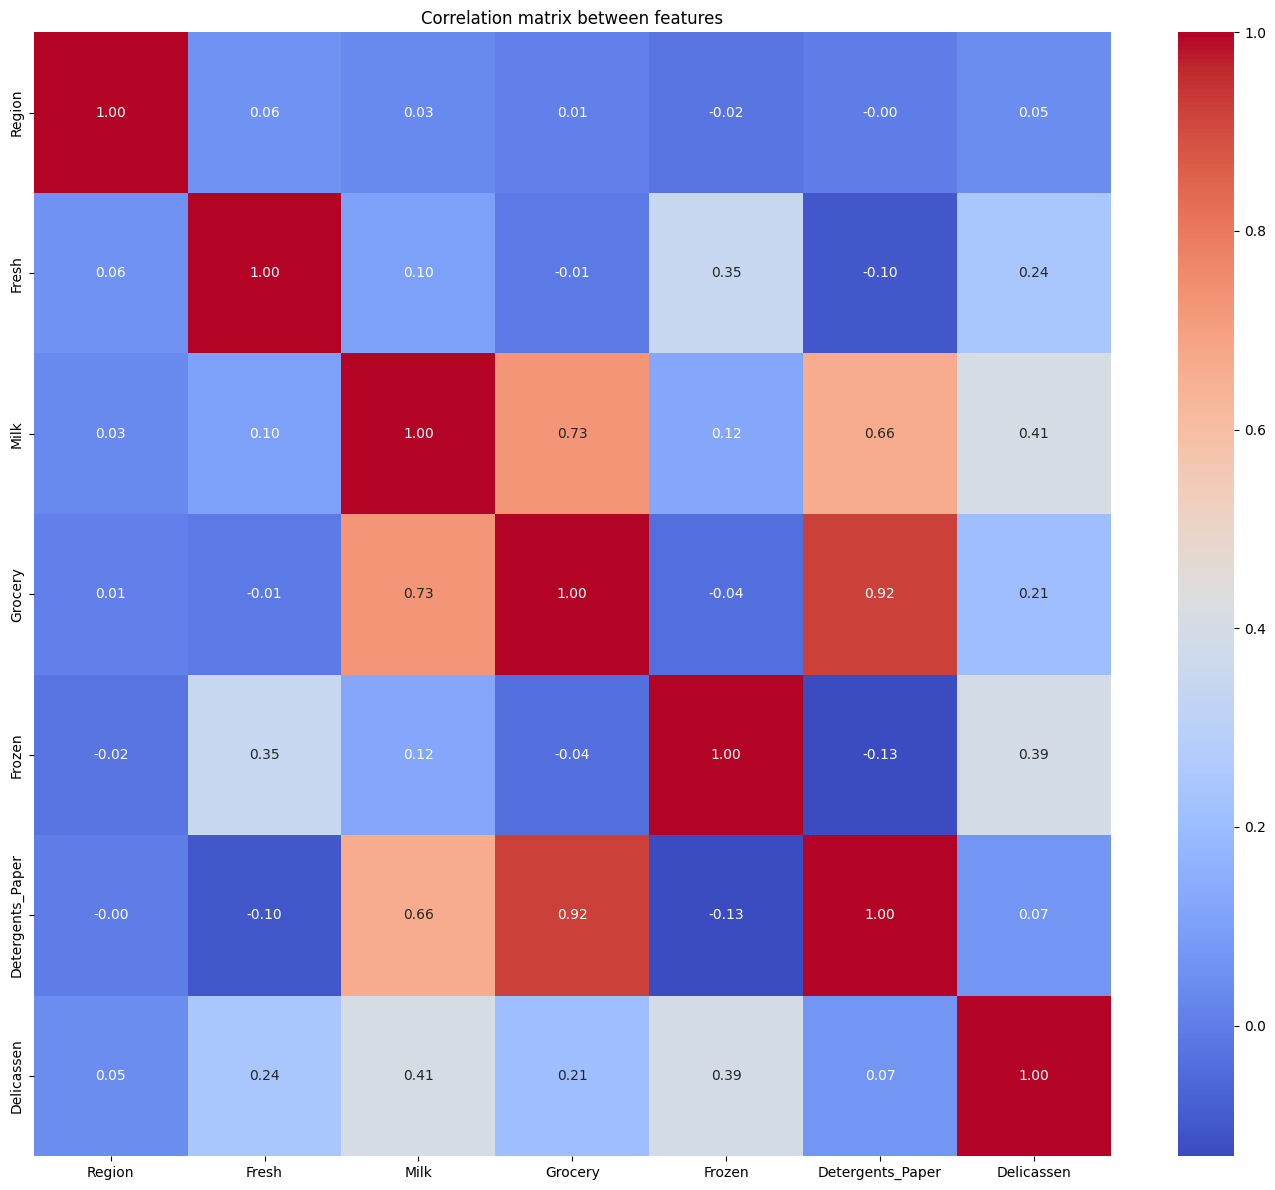

In [26]:
plt.figure(figsize=(14, 12))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation matrix between features')
plt.tight_layout()

In [27]:
# Identify features most correlated with toxicity
corr_with_target = correlation_matrix['Region'].drop('Region').sort_values(ascending=False)
print("\nFeatures most correlated with region:")
print(corr_with_target.head(5))
print("\nFeatures least correlated with region:")
print(corr_with_target.tail(5))


Features most correlated with region:
Fresh               0.055287
Delicassen          0.045212
Milk                0.032288
Grocery             0.007696
Detergents_Paper   -0.001483
Name: Region, dtype: float64

Features least correlated with region:
Delicassen          0.045212
Milk                0.032288
Grocery             0.007696
Detergents_Paper   -0.001483
Frozen             -0.021044
Name: Region, dtype: float64


In [28]:
comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()

In [29]:
if rank == 0:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    print(f"Generated dataset with {X_train.shape[0]} training samples and {X_test.shape[0]} test samples")
else:
    X_train_scaled = None
    X_test_scaled = None
    y_train = None
    y_test = None

Generated dataset with 352 training samples and 88 test samples


In [30]:
X_train_scaled = comm.bcast(X_train_scaled, root=0)
X_test_scaled = comm.bcast(X_test_scaled, root=0)
y_train = comm.bcast(y_train, root=0)
y_test = comm.bcast(y_test, root=0)

In [31]:
hpsvm = HPSVM(tau=1.0, tol=1e-4, max_iter=50)

2025-03-12 16:33:08,306 - HPSVM - INFO - Initialized HPSVM with 1 nodes
2025-03-12 16:33:08,308 - HPSVM - INFO - Parameters: tau=1.0, tol=0.0001, max_iter=50, kernel=linear


In [32]:
hpsvm.fit(X_train_scaled, y_train)

2025-03-12 16:33:08,320 - HPSVM - INFO - Starting HPSVM training with 352 samples and 6 features
2025-03-12 16:33:08,321 - HPSVM - INFO - Data distributed among 1 nodes
2025-03-12 16:33:08,325 - HPSVM - INFO - Iteration 0: duality gap = 0.251992, step size = 0.950000
2025-03-12 16:33:08,331 - HPSVM - INFO - Iteration 5: duality gap = 0.488733, step size = 0.059501
2025-03-12 16:33:08,335 - HPSVM - INFO - Iteration 10: duality gap = 0.490102, step size = 0.000006
2025-03-12 16:33:08,341 - HPSVM - INFO - Iteration 15: duality gap = 0.490167, step size = 0.000003
2025-03-12 16:33:08,345 - HPSVM - INFO - Iteration 20: duality gap = 0.490258, step size = 0.000001
2025-03-12 16:33:08,352 - HPSVM - INFO - Iteration 25: duality gap = 0.490386, step size = 0.000035
2025-03-12 16:33:08,356 - HPSVM - INFO - Iteration 30: duality gap = 0.490548, step size = 0.000028
2025-03-12 16:33:08,361 - HPSVM - INFO - Iteration 35: duality gap = 0.490773, step size = 0.000001
2025-03-12 16:33:08,367 - HPSVM -

In [33]:
accuracy = hpsvm.score(X_test, y_test)
print(f"Test accuracy: {accuracy:.4f}")

Test accuracy: 0.9773


# Apply HPSVM to Hate Speech Dataset

In [34]:
df = pd.read_csv("data/hate_speech_and_offensive_language_dataset.csv")

In [35]:
df.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [36]:
null_count = df.isnull().sum()
null_count

Unnamed: 0            0
count                 0
hate_speech           0
offensive_language    0
neither               0
class                 0
tweet                 0
dtype: int64

In [37]:
print(df.describe())

         Unnamed: 0         count   hate_speech  offensive_language  \
count  24783.000000  24783.000000  24783.000000        24783.000000   
mean   12681.192027      3.243473      0.280515            2.413711   
std     7299.553863      0.883060      0.631851            1.399459   
min        0.000000      3.000000      0.000000            0.000000   
25%     6372.500000      3.000000      0.000000            2.000000   
50%    12703.000000      3.000000      0.000000            3.000000   
75%    18995.500000      3.000000      0.000000            3.000000   
max    25296.000000      9.000000      7.000000            9.000000   

            neither         class  
count  24783.000000  24783.000000  
mean       0.549247      1.110277  
std        1.113299      0.462089  
min        0.000000      0.000000  
25%        0.000000      1.000000  
50%        0.000000      1.000000  
75%        0.000000      1.000000  
max        9.000000      2.000000  


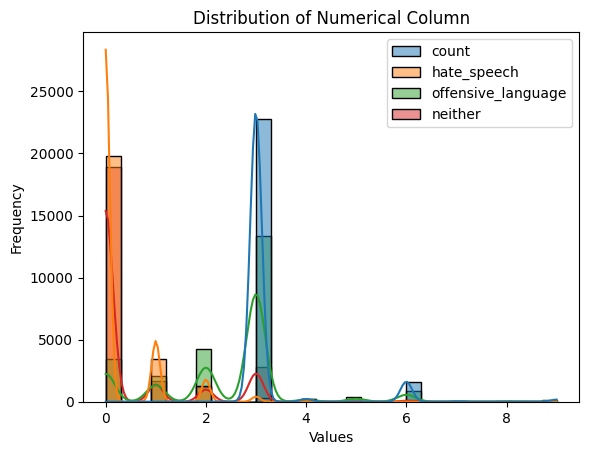

In [38]:
# Plotting the distribution of numerical columns
sns.histplot(df[['count', 'hate_speech', 'offensive_language', 'neither']], bins=30, kde=True)
plt.title("Distribution of Numerical Column")
plt.xlabel("Values")
plt.ylabel("Frequency")
plt.show()

In [39]:
df.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [40]:
X = df.drop(['class', 'Unnamed: 0', 'tweet'], axis=1)
y = df['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 4)

In [ ]:
comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()

if rank == 0:
    # Broadcast data to all nodes
    X_train = comm.bcast(X_train, root=0)
    X_test = comm.bcast(X_test, root=0)
    y_train = comm.bcast(y_train, root=0)
    y_test = comm.bcast(y_test, root=0)
else:
    X_train = None
    X_test = None
    y_train = None
    y_test = None

# Create and train HPSVM model
hpsvm = HPSVM(tau=1.0, tol=1e-4, max_iter=50)

hpsvm.fit(X_train.to_numpy(), y_train.to_numpy())

2025-03-12 16:33:09,672 - HPSVM - INFO - Initialized HPSVM with 1 nodes
2025-03-12 16:33:09,674 - HPSVM - INFO - Parameters: tau=1.0, tol=0.0001, max_iter=50, kernel=linear
2025-03-12 16:33:09,675 - HPSVM - INFO - Starting HPSVM training with 19826 samples and 4 features
2025-03-12 16:33:09,676 - HPSVM - INFO - Data distributed among 1 nodes
2025-03-12 16:33:09,718 - HPSVM - INFO - Iteration 0: duality gap = 0.562741, step size = 0.000004
2025-03-12 16:33:09,832 - HPSVM - INFO - Iteration 5: duality gap = 0.790866, step size = 0.000008
2025-03-12 16:33:09,996 - HPSVM - INFO - Iteration 10: duality gap = 0.804835, step size = 0.000000
2025-03-12 16:33:10,113 - HPSVM - INFO - Iteration 15: duality gap = 0.804835, step size = 0.000000
2025-03-12 16:33:10,204 - HPSVM - INFO - Iteration 20: duality gap = 0.804835, step size = 0.000000
2025-03-12 16:33:10,321 - HPSVM - INFO - Iteration 25: duality gap = 0.804835, step size = 0.000000
2025-03-12 16:33:10,485 - HPSVM - INFO - Iteration 30: dua

In [42]:
if rank == 0:
    # Test the model
    accuracy = hpsvm.score(X_test, y_test)
    print(f"Test accuracy: {accuracy:.4f}")

Test accuracy: 0.9443
